<a href="https://colab.research.google.com/github/Shon40501/MallMate4.0/blob/master/%D7%A4%D7%A8%D7%95%D7%99%D7%A7%D7%98_%D7%97%D7%99%D7%96%D7%95%D7%99_%D7%9E%D7%97%D7%99%D7%A8%D7%99_%D7%9E%D7%95%D7%A6%D7%A8%D7%99%D7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# remove outliers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.cluster import DBSCAN
from nltk.corpus import stopwords
import nltk
import re
from tqdm import tqdm

# Download necessary NLTK data
nltk.download('stopwords', quiet=True)

def preprocess_text(text):
    """Preprocess the text by removing special characters, converting to lowercase, and removing stopwords."""
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])

def batch_detect_outliers(texts, vectorizer, eps=0.5, min_samples=2, batch_size=10000):
    """Detect outliers in batches using HashingVectorizer and DBSCAN."""
    outliers = np.zeros(len(texts), dtype=bool)

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch = texts[i:i+batch_size]
        vectors = vectorizer.transform(batch)

        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine', n_jobs=-1)
        clusters = dbscan.fit_predict(vectors)

        outliers[i:i+batch_size] = (clusters == -1)

    return outliers

def efficient_remove_amazon_product_outliers(df, name_col, desc_col, name_eps=0.5, desc_eps=0.5, sample_size=10000):
    """Remove outliers from Amazon product name and description columns using efficient, intelligent content-based analysis."""

    # Preprocess text data
    df['processed_name'] = df[name_col].apply(preprocess_text)
    df['processed_desc'] = df[desc_col].apply(preprocess_text)

    # Initialize HashingVectorizer
    vectorizer = HashingVectorizer(n_features=2**10)

    # Use a sample to determine eps if needed
    if sample_size:
        sample_df = df.sample(min(sample_size, len(df)))
        sample_vectors = vectorizer.fit_transform(sample_df['processed_name'])
        from sklearn.neighbors import NearestNeighbors
        nn = NearestNeighbors(n_neighbors=2)
        nn.fit(sample_vectors)
        distances, _ = nn.kneighbors(sample_vectors)

        # Set a minimum threshold for eps
        name_eps = max(np.percentile(distances[:, 1], 95), 0.01)

        sample_vectors = vectorizer.fit_transform(sample_df['processed_desc'])
        nn.fit(sample_vectors)
        distances, _ = nn.kneighbors(sample_vectors)

        # Set a minimum threshold for eps
        desc_eps = max(np.percentile(distances[:, 1], 95), 0.01)

    # Detect outliers in product names
    name_outliers = batch_detect_outliers(df['processed_name'].values, vectorizer, eps=name_eps)

    # Detect outliers in product descriptions
    desc_outliers = batch_detect_outliers(df['processed_desc'].values, vectorizer, eps=desc_eps)

    # Combine outlier detection results
    outliers = name_outliers | desc_outliers

    # Remove outliers
    df_clean = df[~outliers].copy()

    # Drop processed columns
    df_clean.drop(['processed_name', 'processed_desc'], axis=1, inplace=True)

    return df_clean

In [ ]:
text_data = clean_df[['title', 'description']]
clean_text_data = efficient_remove_amazon_product_outliers(
    text_data,
    name_col='title',
    desc_col='description',
    sample_size=20000  # Adjust based on your needs
)
print(f"Cleaned DataFrame shape: {clean_text_data.shape}")
print(f"Removed {text_data.shape[0] - clean_text_data.shape[0]} outliers")

NameError: name 'clean_df' is not defined

# loading data and preliminary cleaning

In [ ]:
#הקישןר של שון
#df = pd.read_csv('/content/drive/MyDrive/Amazon Electronics Metadata.csv')

In [ ]:
#הקישור של מיכאל
df = pd.read_csv('/content/drive/MyDrive/מגשימים/מיכאל ושון/Amazon Electronics Metadata.csv')

In [ ]:
df.head()

,asin,imUrl,description,categories,title,price,salesRank,related,brand
0,0132793040,http://ecx.images-amazon.com/images/I/31JIPhp%...,The Kelby Training DVD Mastering Blend Modes i...,"[['Electronics', 'Computers & Accessories', 'C...",Kelby Training DVD: Mastering Blend Modes in A...,NaN,NaN,NaN,NaN
1,0321732944,http://ecx.images-amazon.com/images/I/31uogm6Y...,NaN,"[['Electronics', 'Computers & Accessories', 'C...",Kelby Training DVD: Adobe Photoshop CS5 Crash ...,NaN,NaN,NaN,NaN
2,0439886341,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[['Electronics', 'Computers & Accessories', 'P...",Digital Organizer and Messenger,8.15,{'Electronics': 144944},"{'also_viewed': ['0545016266', 'B009ECM8QY', '...",NaN
3,0511189877,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[['Electronics', 'Accessories & Supplies', 'Au...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,NaN,"{'also_viewed': ['B001KC08A4', 'B00KUL8O0W', '...",NaN
4,0528881469,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[['Electronics', 'GPS & Navigation', 'Vehicle ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498196 entries, 0 to 498195
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   asin         498196 non-null  object 
 1   imUrl        498021 non-null  object 
 2   description  442139 non-null  object 
 3   categories   498196 non-null  object 
 4   title        491192 non-null  object 
 5   price        389693 non-null  float64
 6   salesRank    128706 non-null  object 
 7   related      366959 non-null  object 
 8   brand        141365 non-null  object 
dtypes: float64(1), object(8)
memory usage: 34.2+ MB


In [ ]:
clean_df = df.drop(['related','brand','salesRank','asin'], axis = 1)

In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498196 entries, 0 to 498195
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   imUrl        498021 non-null  object 
 1   description  442139 non-null  object 
 2   categories   498196 non-null  object 
 3   title        491192 non-null  object 
 4   price        389693 non-null  float64
dtypes: float64(1), object(4)
memory usage: 19.0+ MB


In [ ]:
nan_counts = clean_df.isna().sum()
for col, count in nan_counts.items():
    if count > 0:
        print(f"Column '{col}' has {count} NaN values.")

Column 'imUrl' has 175 NaN values.
Column 'description' has 56057 NaN values.
Column 'title' has 7004 NaN values.
Column 'price' has 108503 NaN values.


<Axes: ylabel='NaN Count'>

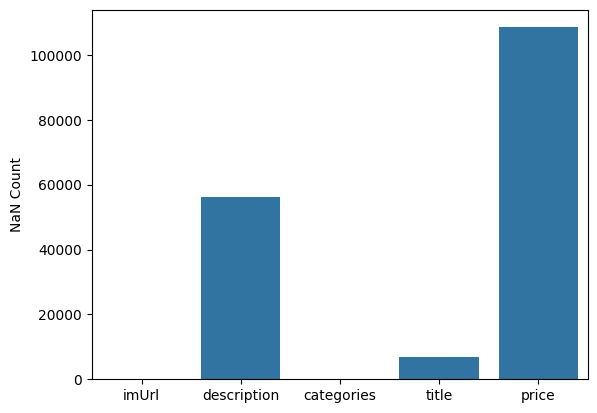

In [ ]:
nan_counts = clean_df.isna().sum()
nan_df = pd.DataFrame({'NaN Count': nan_counts})
sns.barplot(data = nan_df['NaN Count'])

In [ ]:
nan_df

,NaN Count
imUrl,175
description,56057
categories,0
title,7004
price,108503


In [ ]:
clean_df['imUrl'].value_counts()

,count
imUrl,
http://g-ecx.images-amazon.com/images/G/01/x-site/icons/no-img-sm._CB192198896_.gif,1634
http://ecx.images-amazon.com/images/I/318G%2BgN%2BT3L._SX300_.jpg,801
http://ecx.images-amazon.com/images/I/41mLaXG7ZOL._SY300_.jpg,380
http://ecx.images-amazon.com/images/I/41Z-RA9b3hL._SY300_.jpg,370
http://ecx.images-amazon.com/images/I/410qoudVg2L._SY300_.jpg,331
...,...
http://ecx.images-amazon.com/images/I/31iUwoPhnKL._SX300_.jpg,1
http://ecx.images-amazon.com/images/I/41rfYB7SHyL._SX300_.jpg,1
http://ecx.images-amazon.com/images/I/31H54z4NAEL._SX300_.jpg,1


In [ ]:
nan_df['duplicated_sum'] = 0

In [ ]:
nan_df

,NaN Count,duplicated_sum
imUrl,175,0
description,56057,0
categories,0,0
title,7004,0
price,108503,0


In [ ]:
dup_list = []
for column in clean_df:
  product_counts = clean_df[column].value_counts()
  products_with_multiple_rows = len(product_counts[product_counts > 1])
  dup_list.append(products_with_multiple_rows)

In [ ]:
dup_list

[28934, 27496, 1359, 4855, 13222]

In [ ]:
#del dup_list[0]

In [ ]:
nan_df['duplicated_sum'] = dup_list
nan_df

,NaN Count,duplicated_sum
imUrl,175,28934
description,56057,27496
categories,0,1359
title,7004,4855
price,108503,13222


In [ ]:
#nan_df.drop(index=nan_df.index[0], axis=0, inplace=True)

In [ ]:
nan_df

,NaN Count,duplicated_sum
imUrl,175,28934
description,56057,27496
categories,0,1359
title,7004,4855
price,108503,13222


<Axes: ylabel='duplicated_sum'>

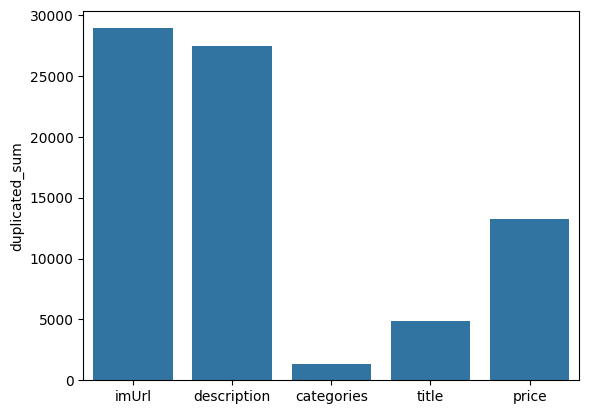

In [ ]:
sns.barplot(data = nan_df['duplicated_sum'])

In [ ]:
clean_df.dropna(subset=['imUrl', 'description', 'title', 'categories', 'price'], inplace=True)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 348682 entries, 2 to 498195
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   imUrl        348682 non-null  object 
 1   description  348682 non-null  object 
 2   categories   348682 non-null  object 
 3   title        348682 non-null  object 
 4   price        348682 non-null  float64
dtypes: float64(1), object(4)
memory usage: 16.0+ MB


<Axes: xlabel='price', ylabel='Count'>

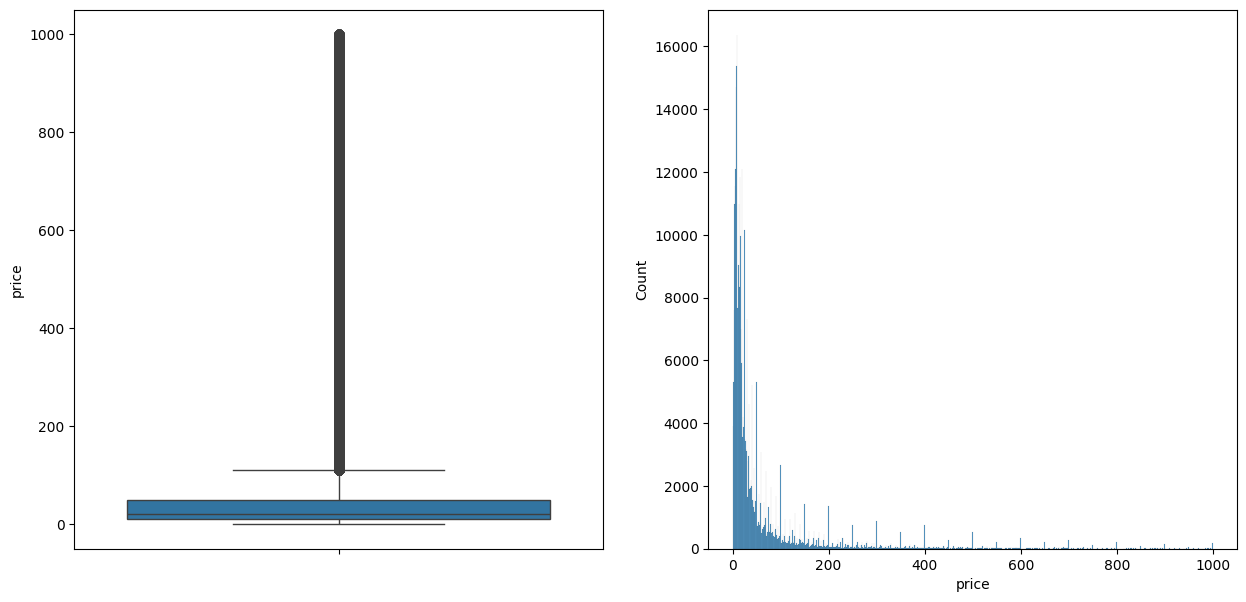

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.boxplot(clean_df['price'], ax = axs[0])
sns.histplot(clean_df['price'], ax=axs[1])

In [ ]:
clean_df.head()

,imUrl,description,categories,title,price
2,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[['Electronics', 'Computers & Accessories', 'P...",Digital Organizer and Messenger,8.15
3,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[['Electronics', 'Accessories & Supplies', 'Au...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36
4,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[['Electronics', 'GPS & Navigation', 'Vehicle ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99
5,http://ecx.images-amazon.com/images/I/21rEirnd...,Use these high quality headphones for internet...,"[['Electronics', 'Accessories & Supplies', 'Au...",Polaroid Pbm2200 PC / Gaming Stereo Headphones...,13.95
6,http://ecx.images-amazon.com/images/I/41kQsHT8...,The Barnes &amp;amp; Noble BNADPN31 Power Kit ...,"[['Electronics', 'eBook Readers & Accessories'...",Barnes &amp; Noble NOOK Power Kit in Carbon BN...,32.10


In [ ]:
known_values = clean_df['price'].dropna()

In [ ]:
len(known_values)

348682

In [ ]:
known_values.max()

999.99

<Axes: xlabel='price', ylabel='Count'>

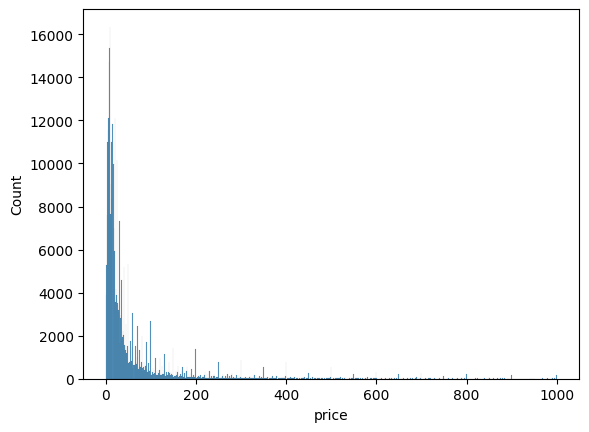

In [ ]:
sns.histplot(known_values)

In [ ]:
import numpy as np
def log_transform_and_impute(series):
  log_series = np.log1p(series) # מוסיף 1 לערכים על מנת שלא נתקל בערכים אפסיים
  known_quantiles = log_series.dropna().quantile(np.linspace(0, 1, 100)) # מסנן ערכים חסרים , נותן קבוצה של ערכים יידועים המייצגים את ההתפלגות ברווח של 100 ערכים
  imputed_log_values = np.random.choice(known_quantiles, size=log_series.isnull().sum())
  imputed_log_series = log_series.copy()
  imputed_log_series[log_series.isnull()] = imputed_log_values
  imputed_series = np.expm1(imputed_log_series)
  return imputed_series

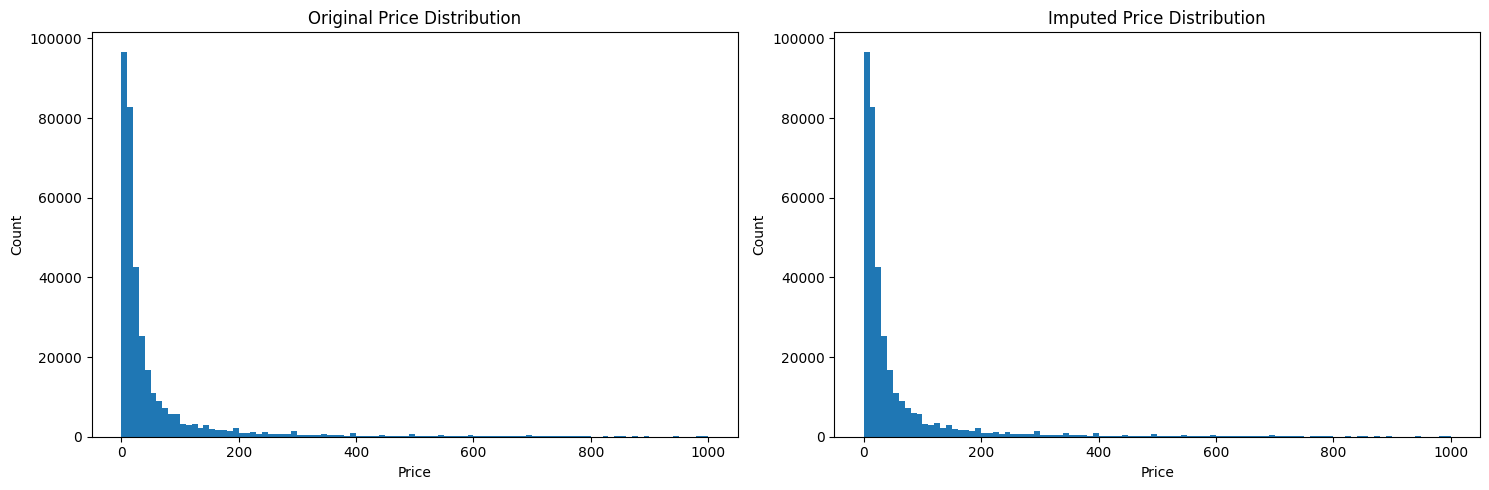

In [ ]:
clean_df['price_imputed'] = log_transform_and_impute(clean_df['price'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(clean_df['price'].dropna(), bins=100, range=(0, 1000))
ax1.set_title('Original Price Distribution')
ax1.set_xlabel('Price')
ax1.set_ylabel('Count')

ax2.hist(clean_df['price_imputed'], bins=100, range=(0, 1000))
ax2.set_title('Imputed Price Distribution')
ax2.set_xlabel('Price')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
clean_df.head()

,imUrl,description,categories,title,price,price_imputed
2,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[['Electronics', 'Computers & Accessories', 'P...",Digital Organizer and Messenger,8.15,8.15
3,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[['Electronics', 'Accessories & Supplies', 'Au...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,23.36
4,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[['Electronics', 'GPS & Navigation', 'Vehicle ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,299.99
5,http://ecx.images-amazon.com/images/I/21rEirnd...,Use these high quality headphones for internet...,"[['Electronics', 'Accessories & Supplies', 'Au...",Polaroid Pbm2200 PC / Gaming Stereo Headphones...,13.95,13.95
6,http://ecx.images-amazon.com/images/I/41kQsHT8...,The Barnes &amp;amp; Noble BNADPN31 Power Kit ...,"[['Electronics', 'eBook Readers & Accessories'...",Barnes &amp; Noble NOOK Power Kit in Carbon BN...,32.10,32.10


In [ ]:
clean_df['imUrl'].value_counts()

,count
imUrl,
http://ecx.images-amazon.com/images/I/318G%2BgN%2BT3L._SX300_.jpg,612
http://ecx.images-amazon.com/images/I/41mLaXG7ZOL._SY300_.jpg,376
http://ecx.images-amazon.com/images/I/410qoudVg2L._SY300_.jpg,326
http://ecx.images-amazon.com/images/I/41ftGJ4t%2B5L._SY300_.jpg,308
http://ecx.images-amazon.com/images/I/41mHaUdJiHL._SX300_.jpg,295
...,...
http://ecx.images-amazon.com/images/I/41AkeIuES%2BL._SY300_.jpg,1
http://ecx.images-amazon.com/images/I/510XgosA2xL._SY300_.jpg,1
http://ecx.images-amazon.com/images/I/41rGpotr5gL._SX300_.jpg,1


In [ ]:
clean_df['categories'].value_counts()

,count
categories,
"[['Electronics', 'Computers & Accessories', 'Touch Screen Tablet Accessories', 'Cases & Sleeves', 'Cases']]",19993
"[['Electronics', 'Computers & Accessories', 'Laptop & Netbook Computer Accessories', 'Batteries']]",13391
"[['Electronics', 'Computers & Accessories', 'Laptop & Netbook Computer Accessories', 'Chargers & Adapters']]",12736
"[['Electronics', 'Accessories & Supplies', 'Audio & Video Accessories', 'Headphones']]",7898
"[['Electronics', 'Portable Audio & Video', 'MP3 Players & Accessories', 'MP3 Player Accessories', 'Cases']]",7057
...,...
"[['Cell Phones & Accessories', 'Accessories', 'Headsets'], ['Electronics', 'Computers & Accessories', 'Cables & Accessories', 'Headsets & Microphones', 'PC Headsets'], ['Office Products', 'Office Electronics']]",1
"[['Electronics', 'Accessories & Supplies', 'Audio & Video Accessories', 'Crossover Parts'], ['Electronics', 'Computers & Accessories', 'External Components', 'KVM Switches']]",1
"[['Cell Phones & Accessories', 'Accessories', 'Headsets'], ['Electronics', 'Accessories & Supplies', 'Telephone Accessories', 'Headsets'], ['Electronics', 'Car & Vehicle Electronics', 'Car Electronics'], ['Office Products', 'Office Electronics', 'Telephones & Accessories', 'Answering Devices'], ['Office Products', 'Office Electronics', 'Telephones & Accessories', 'Corded-Cordless Combo Telephones'], ['Office Products', 'Office Electronics', 'Telephones & Accessories', 'VoIP']]",1


In [ ]:
clean_df['imUrl'].value_counts()

,count
imUrl,
http://ecx.images-amazon.com/images/I/318G%2BgN%2BT3L._SX300_.jpg,612
http://ecx.images-amazon.com/images/I/41mLaXG7ZOL._SY300_.jpg,376
http://ecx.images-amazon.com/images/I/410qoudVg2L._SY300_.jpg,326
http://ecx.images-amazon.com/images/I/41ftGJ4t%2B5L._SY300_.jpg,308
http://ecx.images-amazon.com/images/I/41mHaUdJiHL._SX300_.jpg,295
...,...
http://ecx.images-amazon.com/images/I/41AkeIuES%2BL._SY300_.jpg,1
http://ecx.images-amazon.com/images/I/510XgosA2xL._SY300_.jpg,1
http://ecx.images-amazon.com/images/I/41rGpotr5gL._SX300_.jpg,1


In [ ]:
clean_df = clean_df[clean_df['imUrl'] != 'http://g-ecx.images-amazon.com/images/G/01/x-site/icons/no-img-sm._CB192198896_.gif']

In [ ]:
clean_df['imUrl'].value_counts()

,count
imUrl,
http://ecx.images-amazon.com/images/I/318G%2BgN%2BT3L._SX300_.jpg,612
http://ecx.images-amazon.com/images/I/41mLaXG7ZOL._SY300_.jpg,376
http://ecx.images-amazon.com/images/I/410qoudVg2L._SY300_.jpg,326
http://ecx.images-amazon.com/images/I/41ftGJ4t%2B5L._SY300_.jpg,308
http://ecx.images-amazon.com/images/I/41mHaUdJiHL._SX300_.jpg,295
...,...
http://ecx.images-amazon.com/images/I/41AkeIuES%2BL._SY300_.jpg,1
http://ecx.images-amazon.com/images/I/510XgosA2xL._SY300_.jpg,1
http://ecx.images-amazon.com/images/I/41rGpotr5gL._SX300_.jpg,1


In [ ]:
clean_df[clean_df['imUrl'] == 'http://ecx.images-amazon.com/images/I/318G%2BgN%2BT3L._SX300_.jpg']

,imUrl,description,categories,title,price,price_imputed
180268,http://ecx.images-amazon.com/images/I/318G%2Bg...,Note: You will receive a 100% comaptible scree...,"[['Electronics', 'Computers & Accessories', 'L...",Brand New 15.6&quot; WXGA Glossy Laptop LED Sc...,37.89,37.89
183245,http://ecx.images-amazon.com/images/I/318G%2Bg...,"You are purchasing a BRAND NEW 15.6"" WXGA HD G...","[['Electronics', 'Computers & Accessories', 'L...",NEW 15.6&quot; LED LAPTOP SCREEN FITS Samsung ...,42.71,42.71
183254,http://ecx.images-amazon.com/images/I/318G%2Bg...,"You are purchasing a BRAND NEW 15.6"" WXGA HD G...","[['Electronics', 'Computers & Accessories', 'L...",15.6&quot; FOR ACER ASPIRE 5251-1805 LAPTOP LC...,48.98,48.98
183289,http://ecx.images-amazon.com/images/I/318G%2Bg...,"You are purchasing a BRAND NEW 15.6"" WXGA HD G...","[['Electronics', 'Computers & Accessories', 'L...",15.6&quot; FOR ASUS K50IJ LAPTOP LCD SCREEN 15...,45.42,45.42
183300,http://ecx.images-amazon.com/images/I/318G%2Bg...,"You are purchasing a BRAND NEW 15.6"" WXGA HD G...","[['Electronics', 'Computers & Accessories', 'L...",NEW 15.6&quot; FOR Dell Inspiron N5040 LAPTOP ...,48.48,48.48
...,...,...,...,...,...,...
468712,http://ecx.images-amazon.com/images/I/318G%2Bg...,Please match your original screen's BACKLIGHT ...,"[['Electronics', 'Computers & Accessories', 'M...",TOSHIBA SATELLITE C855D-S5116 LAPTOP LCD SCREE...,48.98,48.98
487969,http://ecx.images-amazon.com/images/I/318G%2Bg...,Please match your original screen's BACKLIGHT ...,"[['Electronics', 'Computers & Accessories', 'M...",HP 2000-2C11NR LAPTOP LCD SCREEN 15.6&quot; WX...,45.54,45.54
487972,http://ecx.images-amazon.com/images/I/318G%2Bg...,Please match your original screen's BACKLIGHT ...,"[['Electronics', 'Computers & Accessories', 'M...",HP PAVILION G6-2217CL LAPTOP LCD SCREEN 15.6&q...,45.54,45.54
492234,http://ecx.images-amazon.com/images/I/318G%2Bg...,Please match your original screen's BACKLIGHT ...,"[['Electronics', 'Computers & Accessories', 'M...",TOSHIBA SATELLITE PRO C650-EZ1524D LAPTOP LCD ...,45.54,45.54


# Feature Engineering

In [ ]:
clean_df

,imUrl,description,categories,title,price,price_imputed
2,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[['Electronics', 'Computers & Accessories', 'P...",Digital Organizer and Messenger,8.15,8.15
3,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[['Electronics', 'Accessories & Supplies', 'Au...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,23.36
4,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[['Electronics', 'GPS & Navigation', 'Vehicle ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,299.99
5,http://ecx.images-amazon.com/images/I/21rEirnd...,Use these high quality headphones for internet...,"[['Electronics', 'Accessories & Supplies', 'Au...",Polaroid Pbm2200 PC / Gaming Stereo Headphones...,13.95,13.95
6,http://ecx.images-amazon.com/images/I/41kQsHT8...,The Barnes &amp;amp; Noble BNADPN31 Power Kit ...,"[['Electronics', 'eBook Readers & Accessories'...",Barnes &amp; Noble NOOK Power Kit in Carbon BN...,32.10,32.10
...,...,...,...,...,...,...
498191,http://ecx.images-amazon.com/images/I/313e6SJm...,Vehicle suction cup mount (replacement) NOTICE...,"[['Electronics', 'GPS & Navigation', 'GPS Syst...",Suction Cup Mount,21.99,21.99
498192,http://ecx.images-amazon.com/images/I/31oF9oNv...,Quatech - 1 Port PCMCIA to DB-25 Parallel Adap...,"[['Electronics', 'Computers & Accessories', 'C...",Parallel PCMCIA Card 1PORT Epp,23.99,23.99
498193,http://ecx.images-amazon.com/images/I/21WIrX5f...,C2G - 5m Ultma USB 2.0 A Mini B Cble,"[['Electronics', 'Computers & Accessories', 'C...",C2G / Cables to Go 5M Ultima USB 2.0 Cable,18.91,18.91
498194,http://ecx.images-amazon.com/images/I/41TNAVmf...,Keyboard drawer.,"[['Electronics', 'Computers & Accessories', 'C...",Underdesk Keyboard Drawer,25.54,25.54


In [ ]:
clean_df.drop_duplicates()

,imUrl,description,categories,title,price,price_imputed
2,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[['Electronics', 'Computers & Accessories', 'P...",Digital Organizer and Messenger,8.15,8.15
3,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[['Electronics', 'Accessories & Supplies', 'Au...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,23.36
4,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[['Electronics', 'GPS & Navigation', 'Vehicle ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,299.99
5,http://ecx.images-amazon.com/images/I/21rEirnd...,Use these high quality headphones for internet...,"[['Electronics', 'Accessories & Supplies', 'Au...",Polaroid Pbm2200 PC / Gaming Stereo Headphones...,13.95,13.95
6,http://ecx.images-amazon.com/images/I/41kQsHT8...,The Barnes &amp;amp; Noble BNADPN31 Power Kit ...,"[['Electronics', 'eBook Readers & Accessories'...",Barnes &amp; Noble NOOK Power Kit in Carbon BN...,32.10,32.10
...,...,...,...,...,...,...
498191,http://ecx.images-amazon.com/images/I/313e6SJm...,Vehicle suction cup mount (replacement) NOTICE...,"[['Electronics', 'GPS & Navigation', 'GPS Syst...",Suction Cup Mount,21.99,21.99
498192,http://ecx.images-amazon.com/images/I/31oF9oNv...,Quatech - 1 Port PCMCIA to DB-25 Parallel Adap...,"[['Electronics', 'Computers & Accessories', 'C...",Parallel PCMCIA Card 1PORT Epp,23.99,23.99
498193,http://ecx.images-amazon.com/images/I/21WIrX5f...,C2G - 5m Ultma USB 2.0 A Mini B Cble,"[['Electronics', 'Computers & Accessories', 'C...",C2G / Cables to Go 5M Ultima USB 2.0 Cable,18.91,18.91
498194,http://ecx.images-amazon.com/images/I/41TNAVmf...,Keyboard drawer.,"[['Electronics', 'Computers & Accessories', 'C...",Underdesk Keyboard Drawer,25.54,25.54


# categories FE

In [ ]:
import ast

# Function to flatten nested lists
def flatten(lst):
    lst = ast.literal_eval(lst)
    result = []
    for item in lst:
        result.extend(item)
    return result

cat_df = clean_df[['categories']]

# Apply the flattening function to the 'categories' column
cat_df.loc[:, 'categories'] = cat_df['categories'].apply(flatten)
cat_df_copy = cat_df.copy()
cat_df = cat_df_copy.copy()

In [ ]:
max_len = 0
for cat_lst in cat_df['categories']:
  if len(cat_lst) > max_len:
    max_len = len(cat_lst)
print(max_len)
for i in range(23):
  cat_df.loc[:, f"category_{i}"] = None
cat_df = cat_df.apply(lambda row: row.update({f"category_{j}": cat for j, cat in enumerate(row['categories'])}) or row, axis=1)
print(cat_df.shape)
print(cat_df.info())
cat_df.sample(3)

23
(348411, 24)
<class 'pandas.core.frame.DataFrame'>
Index: 348411 entries, 2 to 498195
Data columns (total 24 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   categories   348411 non-null  object
 1   category_0   348411 non-null  object
 2   category_1   348411 non-null  object
 3   category_2   343890 non-null  object
 4   category_3   316608 non-null  object
 5   category_4   161904 non-null  object
 6   category_5   32423 non-null   object
 7   category_6   1731 non-null    object
 8   category_7   1213 non-null    object
 9   category_8   525 non-null     object
 10  category_9   245 non-null     object
 11  category_10  135 non-null     object
 12  category_11  104 non-null     object
 13  category_12  63 non-null      object
 14  category_13  39 non-null      object
 15  category_14  27 non-null      object
 16  category_15  25 non-null      object
 17  category_16  13 non-null      object
 18  category_17  12 non-null      obj

,categories,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,...,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20,category_21,category_22
342738,"[Electronics, Portable Audio & Video, MP3 Play...",Electronics,Portable Audio & Video,MP3 Players & Accessories,MP3 Player Accessories,Speaker Systems,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
179403,"[Electronics, Television & Video, Home Theater...",Electronics,Television & Video,Home Theater Systems,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
189574,"[Electronics, Portable Audio & Video, Digital ...",Electronics,Portable Audio & Video,Digital Voice Recorders,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
cat_unique = {}
#drop the category levels that wont help the model
#cat 1 dropped because almost everything is one value
#all others dropped because of not enough values
cat_df = cat_df.loc[:, 'category_1':'category_5']
for col in cat_df:
  cat_unique[col] = list(cat_df[col].value_counts())
#  print(col)
#  print(cat_df[col].nunique())
print(cat_unique)

{'category_1': [161915, 70041, 51558, 21695, 19028, 5342, 5282, 5010, 3181, 2761, 1105, 983, 485, 8, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1], 'category_2': [43347, 39264, 36723, 34176, 32759, 18364, 16525, 10541, 8790, 7622, 7539, 7013, 6127, 5419, 4951, 4743, 4152, 3316, 3008, 2896, 2622, 2595, 2314, 2048, 2018, 1970, 1884, 1715, 1585, 1441, 1409, 1289, 1247, 1155, 1085, 1074, 1048, 1041, 1034, 957, 950, 856, 813, 791, 749, 709, 697, 648, 604, 575, 531, 423, 402, 354, 336, 328, 318, 281, 262, 252, 234, 204, 202, 197, 187, 186, 178, 142, 142, 139, 136, 134, 133, 130, 121, 115, 99, 97, 93, 92, 91, 91, 86, 84, 82, 69, 67, 59, 59, 53, 52, 52, 50, 45, 36, 35, 31, 29, 28, 20, 15, 13, 11, 11, 11, 8, 8, 5, 5, 4, 4, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'category_3': [23062, 20908, 16041, 14672, 13926, 12408, 9364, 7898, 6649, 6399, 5620, 5195, 4725, 4383, 4224, 4104, 3906, 3707, 3586, 3460, 3379, 3363, 3317, 3304, 3209, 3039, 3037, 2836, 2808, 2716, 2681, 2644, 2590, 232

In [ ]:
import pandas as pd
import numpy as np

def group_rare_categories(df, column, threshold_method='quartile', threshold_value=0.8):
    # Count of each category
    category_counts = df[column].value_counts()

    # Calculate threshold based on method
    if threshold_method == 'quartile':
        # Find threshold at specified quartile
        threshold = category_counts.quantile(threshold_value)
    elif threshold_method == 'percentage':
        # Calculate threshold based on percentage of total rows
        threshold = len(df) * threshold_value
    elif threshold_method == 'absolute':
        # Use the provided absolute number
        threshold = threshold_value
    else:
        raise ValueError("Invalid threshold method")

    # Create a mapping where rare categories become 'Other'
    def _map_categories(category):
      if category is None:
        return "None"
      return category if category_counts[category] >= threshold else 'Other'

    # Create a copy of the dataframe with mapped categories
    df_grouped = df.copy()
    df_grouped[column] = df_grouped[column].apply(_map_categories)

    return df_grouped

def frequency_encode(df, column):
    freq_map = df[column].value_counts(normalize=True)  # Normalize gives proportions
    return df[column].map(freq_map)

cat_df['category_1'] = frequency_encode(group_rare_categories(cat_df, 'category_1'), 'category_1')
cat_df['category_2'] = frequency_encode(group_rare_categories(cat_df, 'category_2', threshold_value=0.8), 'category_2')
cat_df['category_3'] = frequency_encode(group_rare_categories(cat_df, 'category_3', threshold_value=0.7), 'category_3')
cat_df['category_4'] = cat_df['category_4'].apply(lambda x: 0 if x is None else 1)
cat_df['category_5'] = cat_df['category_5'].apply(lambda x: 0 if x is None else 1)

cat_df.head()

,category_1,category_2,category_3,category_4,category_5
2,0.464724,0.089446,0.076814,0,0
3,0.147980,0.105401,0.007589,1,0
4,0.069384,0.089446,0.076814,0,0
5,0.147980,0.105401,0.022669,0,0
6,0.069384,0.089446,0.091280,0,0


In [ ]:
cat_df.describe()

,category_1,category_2,category_3,category_4,category_5
count,348411.000000,348411.000000,348411.000000,348411.000000,348411.000000
mean,0.289954,0.075451,0.034316,0.464693,0.093060
std,0.168510,0.040912,0.030007,0.498753,0.290516
min,0.054614,0.005407,0.001490,0.000000,0.000000
25%,0.147980,0.030254,0.007795,0.000000,0.000000
50%,0.201030,0.094024,0.022669,0.000000,0.000000
75%,0.464724,0.105401,0.060010,1.000000,0.000000
max,0.464724,0.124413,0.091280,1.000000,1.000000


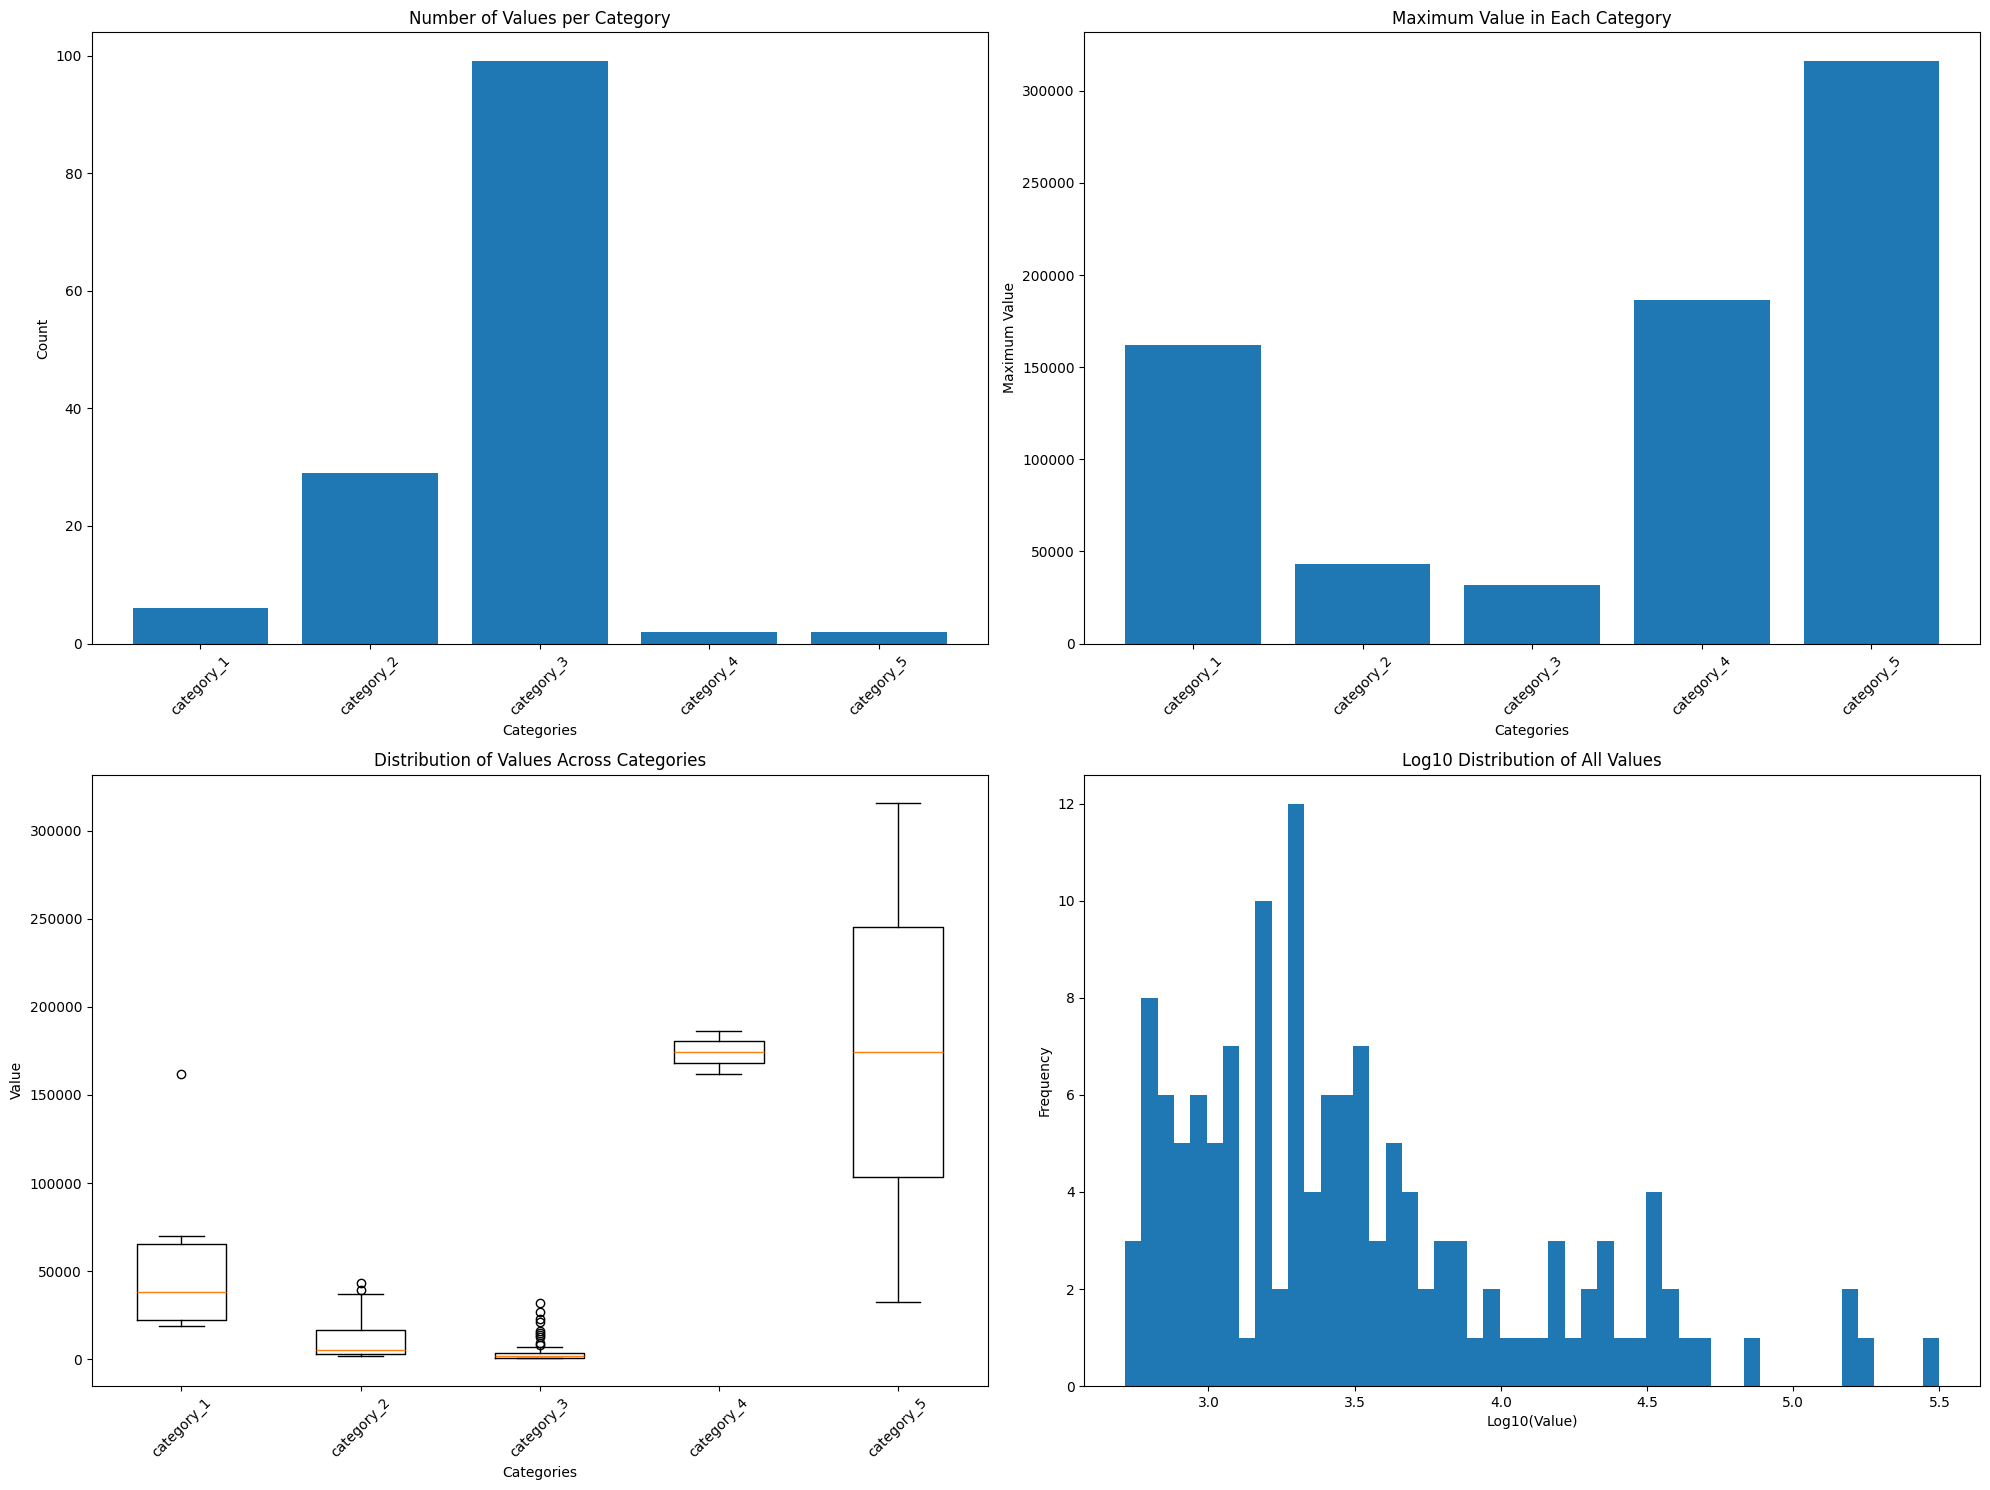

In [ ]:
# @title analyze categories distribution

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

data = {}
for col in cat_df:
  data[col] = list(cat_df[col].value_counts())

# Prepare data for visualization
def analyze_category_data(data):
    category_lengths = {cat: len(values) for cat, values in data.items()}
    category_max_values = {cat: max(values) for cat, values in data.items()}
    return category_lengths, category_max_values

lengths, max_values = analyze_category_data(data)

# Create subplots
plt.figure(figsize=(20, 15))

# 1. Bar plot of category lengths
plt.subplot(2, 2, 1)
plt.bar(lengths.keys(), lengths.values())
plt.title('Number of Values per Category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)

# 2. Bar plot of maximum values in each category
plt.subplot(2, 2, 2)
plt.bar(max_values.keys(), max_values.values())
plt.title('Maximum Value in Each Category')
plt.xlabel('Categories')
plt.ylabel('Maximum Value')
plt.xticks(rotation=45)

# 3. Boxplot of category distributions
plt.subplot(2, 2, 3)
boxplot_data = [values for values in data.values()]
plt.boxplot(boxplot_data)
plt.title('Distribution of Values Across Categories')
plt.xlabel('Categories')
plt.ylabel('Value')
plt.xticks(range(1, len(data) + 1), list(data.keys()), rotation=45)

# 4. Logarithmic distribution plot
plt.subplot(2, 2, 4)
all_values = [val for sublist in data.values() for val in sublist]
plt.hist(np.log10(all_values), bins=50)
plt.title('Log10 Distribution of All Values')
plt.xlabel('Log10(Value)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
cat_df.head()

,category_1,category_2,category_3,category_4,category_5
2,0.464724,0.089446,0.076814,0,0
3,0.147980,0.105401,0.007589,1,0
4,0.069384,0.089446,0.076814,0,0
5,0.147980,0.105401,0.022669,0,0
6,0.069384,0.089446,0.091280,0,0


In [ ]:
cat_df

,category_1,category_2,category_3,category_4,category_5
2,0.464724,0.089446,0.076814,0,0
3,0.147980,0.105401,0.007589,1,0
4,0.069384,0.089446,0.076814,0,0
5,0.147980,0.105401,0.022669,0,0
6,0.069384,0.089446,0.091280,0,0
...,...,...,...,...,...
498191,0.069384,0.011917,0.005557,0,0
498192,0.464724,0.112694,0.060010,1,0
498193,0.464724,0.112694,0.060010,1,0
498194,0.464724,0.112694,0.009483,0,0


# first model ---- td-idf to text columns and then combining their outputs + extract image features using a pre-trained CNN + combine text and image features into a single matrix + train an XGBoost model on the combined feature matrix

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(clean_df['description'])  # Replace `descriptions` with your column
print("Number of unique words in descriptions:", len(vectorizer.vocabulary_))


Number of unique words in descriptions: 476055


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(clean_df['categories'])  # Replace `descriptions` with your column
print("Number of unique words in descriptions:", len(vectorizer.vocabulary_))

Number of unique words in descriptions: 782


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(clean_df['title'])  # Replace `descriptions` with your column
print("Number of unique words in descriptions:", len(vectorizer.vocabulary_))

Number of unique words in descriptions: 223727


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import pandas as pd

descriptions = clean_df['description']
titles = clean_df['title']
categories = clean_df['categories']

# Initialize TF-IDF Vectorizers with adjusted max_features
tfidf_desc = TfidfVectorizer(max_features=10000, stop_words='english')  # For descriptions    #10,000 - 50,000
tfidf_title = TfidfVectorizer(max_features=500, stop_words='english')  # For titles    #500 - 700
tfidf_cat = TfidfVectorizer(max_features=10000, stop_words='english')     # For categories    #10,000 - 30,000

# Fit and transform each column
desc_features = tfidf_desc.fit_transform(descriptions)
title_features = tfidf_title.fit_transform(titles)
cat_features = tfidf_cat.fit_transform(categories)

# Combine the features
from scipy.sparse import hstack
combined_features = hstack([desc_features, title_features, cat_features])

print(f"Combined TF-IDF feature matrix shape: {combined_features.shape}")


Combined TF-IDF feature matrix shape: (348411, 11271)


# Images FE


In [ ]:
import os
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
from tqdm import tqdm
import time

# Function to download a single image with retries
def download_image(url, save_path, retries=3):
    for attempt in range(retries):
        try:
            response = requests.get(url, stream=True, timeout=10)
            if response.status_code == 200:
                with open(save_path, 'wb') as f:
                    for chunk in response.iter_content(1024):
                        f.write(chunk)
                return True
            else:
                print(f"Failed to download {url}: Status code {response.status_code}")
        except Exception as e:
            print(f"Error downloading {url}: {e}")
        time.sleep(1)  # Wait before retrying
    return False

os.makedirs("images", exist_ok=True)


if 'imUrl' not in clean_df.columns:
    raise ValueError("The dataset does not have an 'imUrl' column.")

image_urls = clean_df[['imUrl']].dropna()
print(f"Total image URLs: {len(image_urls)}")


def download_wrapper(index, url):
    save_path = f"images/image_{index}.jpg"
    success = download_image(url, save_path)
    return (index, success)

max_workers = 50

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(download_wrapper, index, row['imUrl']): index for index, row in image_urls.iterrows()}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading images"):
        index = futures[future]
        try:
           _, success = future.result()
            if not success:
                print(f"Failed to download image at row {index}")
        except Exception as e:
            print(f"Exception occurred for image at row {index}: {e}")

print("Image downloading completed.")


Total image URLs: 348411
Failed to download http://ecx.images-amazon.com/images/I/51RC63MR1YL._SX300_.jpg: Status code 404
Failed to download http://ecx.images-amazon.com/images/I/51RC63MR1YL._SX300_.jpg: Status code 404
Failed to download http://ecx.images-amazon.com/images/I/51RC63MR1YL._SX300_.jpg: Status code 404
Failed to download http://ecx.images-amazon.com/images/I/51QZGVPJY8L._SY300_.jpg: Status code 404
Failed to download http://ecx.images-amazon.com/images/I/51PRS2FQAHL._SY300_.jpg: Status code 404
Failed to download http://ecx.images-amazon.com/images/I/51QZGVPJY8L._SY300_.jpg: Status code 404
Failed to download http://ecx.images-amazon.com/images/I/51PRS2FQAHL._SY300_.jpg: Status code 404
Failed to download http://ecx.images-amazon.com/images/I/51QZGVPJY8L._SY300_.jpg: Status code 404
Failed to download http://ecx.images-amazon.com/images/I/51PRS2FQAHL._SY300_.jpg: Status code 404
Failed to download http://ecx.images-amazon.com/images/I/51XF3XG9V4L._SX300_.jpg: Status code

Failed to download image at row 43376
Failed to download image at row 25448
Failed to download image at row 64635
Failed to download image at row 56747
Failed to download image at row 57852
Failed to download image at row 67733
Failed to download image at row 65191
Failed to download image at row 11163


Failed to download image at row 64833
Failed to download image at row 11432
Failed to download image at row 64978
Failed to download image at row 64954
Failed to download image at row 72800


Failed to download image at row 6901
Failed to download image at row 7376
Failed to download image at row 1848
Failed to download image at row 71916
Failed to download image at row 12695
Failed to download image at row 65175
Failed to download image at row 12413
Failed to download image at row 33157


Failed to download image at row 68923
Failed to download image at row 74554


Failed to download image at row 73821
Failed to download image at row 23101
Failed to download image at row 34444


Failed to download image at row 17596


Failed to download image at row 70367
Failed to download image at row 67604
Failed to download image at row 35220


Failed to download image at row 89029
Failed to download image at row 38880
Failed to download image at row 18308


Failed to download image at row 73855
Failed to download image at row 30743
Failed to download image at row 51310
Failed to download image at row 72829
Failed to download image at row 49400


Image downloading completed.


In [ ]:
from PIL import Image
import os

def resize_images(input_dir, output_dir, size=(224, 224)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for file in os.listdir(input_dir):
        if file.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(input_dir, file)
                img = Image.open(img_path).convert("RGB")
                img_resized = img.resize(size, Image.Resampling.LANCZOS)
                img_resized.save(os.path.join(output_dir, file))
            except Exception as e:
                print(f"Failed to process {file}: {e}")
resize_images("/content/images", "/content/resized_images", size=(224, 224))


In [ ]:
import tensorflow as tf
import os

def normalize_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for file_name in os.listdir(input_dir):
        if file_name.endswith(('.jpg', '.jpeg', '.png')):
            try:
                img_path = os.path.join(input_dir, file_name)
                img = tf.io.read_file(img_path)
                img = tf.image.decode_image(img, channels=3)
                img = tf.image.convert_image_dtype(img, tf.float32)
                output_file_path = os.path.join(output_dir, file_name)
                tf.keras.preprocessing.image.save_img(output_file_path, img.numpy())
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
input_directory = "/content/resized_images"
output_directory = "/content/normalized_images"
normalize_images(input_directory, output_directory)


In [ ]:
import os
import pandas as pd

def create_metadata(image_dir, output_path):
    try:
        output_dir = os.path.dirname(output_path)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        filenames = [file for file in os.listdir(image_dir) if file.endswith(('.jpg', '.jpeg', '.png'))]
        metadata = pd.DataFrame(filenames, columns=['filename'])
        metadata.to_csv(output_path, index=False)
        print(f"Metadata file created and saved to {output_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
image_dir = "/content/resized_images"
output_path = "/mnt/data/metadata.csv"

create_metadata(image_dir, output_path)


Metadata file created and saved to /mnt/data/metadata.csv


In [ ]:
import pandas as pd
import os

def update_metadata(metadata_path, image_dir, output_path):
    try:
        metadata = pd.read_csv(metadata_path)
        if 'filename' not in metadata.columns:
            raise ValueError("The metadata file does not have a 'filename' column.")
        existing_images = set(os.listdir(image_dir))
        updated_metadata = metadata[metadata['filename'].isin(existing_images)]
        updated_metadata.to_csv(output_path, index=False)
        print(f"Updated metadata saved to {output_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
metadata_path = "/mnt/data/metadata.csv"
image_dir = "/content/resized_images"
output_path = "/mnt/data/updated_metadata.csv"

update_metadata(metadata_path, image_dir, output_path)


Updated metadata saved to /mnt/data/updated_metadata.csv


In [ ]:
ran_df = clean_df.copy()

In [ ]:
ran_df

,imUrl,description,categories,title,price,price_imputed
2,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[['Electronics', 'Computers & Accessories', 'P...",Digital Organizer and Messenger,8.15,8.15
3,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[['Electronics', 'Accessories & Supplies', 'Au...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,23.36
4,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[['Electronics', 'GPS & Navigation', 'Vehicle ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,299.99
5,http://ecx.images-amazon.com/images/I/21rEirnd...,Use these high quality headphones for internet...,"[['Electronics', 'Accessories & Supplies', 'Au...",Polaroid Pbm2200 PC / Gaming Stereo Headphones...,13.95,13.95
6,http://ecx.images-amazon.com/images/I/41kQsHT8...,The Barnes &amp;amp; Noble BNADPN31 Power Kit ...,"[['Electronics', 'eBook Readers & Accessories'...",Barnes &amp; Noble NOOK Power Kit in Carbon BN...,32.10,32.10
...,...,...,...,...,...,...
498191,http://ecx.images-amazon.com/images/I/313e6SJm...,Vehicle suction cup mount (replacement) NOTICE...,"[['Electronics', 'GPS & Navigation', 'GPS Syst...",Suction Cup Mount,21.99,21.99
498192,http://ecx.images-amazon.com/images/I/31oF9oNv...,Quatech - 1 Port PCMCIA to DB-25 Parallel Adap...,"[['Electronics', 'Computers & Accessories', 'C...",Parallel PCMCIA Card 1PORT Epp,23.99,23.99
498193,http://ecx.images-amazon.com/images/I/21WIrX5f...,C2G - 5m Ultma USB 2.0 A Mini B Cble,"[['Electronics', 'Computers & Accessories', 'C...",C2G / Cables to Go 5M Ultima USB 2.0 Cable,18.91,18.91
498194,http://ecx.images-amazon.com/images/I/41TNAVmf...,Keyboard drawer.,"[['Electronics', 'Computers & Accessories', 'C...",Underdesk Keyboard Drawer,25.54,25.54


In [ ]:
ran_df['imUrl'] = ran_df.index.map(lambda x: f'image_{x}.jpg')

In [ ]:
ran_df.rename(columns={"imUrl": "filename"} , inplace = True)

In [ ]:
ran_df.drop(['price_imputed'], axis=1 , inplace = True)

In [ ]:
ran_df = pd.concat([ran_df, cat_df], axis=1)

In [ ]:
ran_df.drop(['categories'], axis=1 , inplace = True)

In [ ]:
ran_df

,filename,description,title,price,category_1,category_2,category_3,category_4,category_5
2,image_2.jpg,Digital Organizer and Messenger,Digital Organizer and Messenger,8.15,0.464724,0.089446,0.076814,0,0
3,image_3.jpg,The CLIKR-5 UR5U-8780L remote control is desig...,CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,0.147980,0.105401,0.007589,1,0
4,image_4.jpg,"Like its award-winning predecessor, the Intell...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,0.069384,0.089446,0.076814,0,0
5,image_5.jpg,Use these high quality headphones for internet...,Polaroid Pbm2200 PC / Gaming Stereo Headphones...,13.95,0.147980,0.105401,0.022669,0,0
6,image_6.jpg,The Barnes &amp;amp; Noble BNADPN31 Power Kit ...,Barnes &amp; Noble NOOK Power Kit in Carbon BN...,32.10,0.069384,0.089446,0.091280,0,0
...,...,...,...,...,...,...,...,...,...
498191,image_498191.jpg,Vehicle suction cup mount (replacement) NOTICE...,Suction Cup Mount,21.99,0.069384,0.011917,0.005557,0,0
498192,image_498192.jpg,Quatech - 1 Port PCMCIA to DB-25 Parallel Adap...,Parallel PCMCIA Card 1PORT Epp,23.99,0.464724,0.112694,0.060010,1,0
498193,image_498193.jpg,C2G - 5m Ultma USB 2.0 A Mini B Cble,C2G / Cables to Go 5M Ultima USB 2.0 Cable,18.91,0.464724,0.112694,0.060010,1,0
498194,image_498194.jpg,Keyboard drawer.,Underdesk Keyboard Drawer,25.54,0.464724,0.112694,0.009483,0,0


In [ ]:
update_metadata_df = pd.read_csv('/mnt/data/updated_metadata.csv')

In [ ]:
update_metadata_df

,filename
0,image_220526.jpg
1,image_472057.jpg
2,image_176847.jpg
3,image_397517.jpg
4,image_291730.jpg
...,...
348368,image_47556.jpg
348369,image_223227.jpg
348370,image_99567.jpg
348371,image_479751.jpg


In [ ]:
import pandas as pd

def merge_metadata_with_textual_data(metadata, textual_data):
    if 'filename' not in metadata.columns:
        raise ValueError("The metadata DataFrame must contain a 'filename' column.")
    if 'filename' not in textual_data.columns:
        raise ValueError("The textual data DataFrame must contain a 'filename' column.")
    merged_df = pd.merge(metadata, textual_data, on='filename', how='inner')
    return merged_df
merged_df = merge_metadata_with_textual_data(update_metadata_df, ran_df)
print(merged_df.head())
merged_df.to_csv("merged_data.csv", index=False)


           filename                                        description  \
0  image_220526.jpg  You are purchasing a BRAND NEW 14.0" WXGA HD G...   
1  image_472057.jpg                              RENUIT BATT REGEN USB   
2  image_176847.jpg  Maxell, the makers of Jelleez, Peanutz and M&M...   
3  image_397517.jpg  Capture your favorite moment with Disney's Car...   
4  image_291730.jpg  A stylish black cover made from high quality n...   

                                               title  price  category_1  \
0  LG PHILIPS LP140WH1(TL)(C6) / LP140WH1-TLC6 LA...  32.03    0.464724   
1           The Amazing VIATEK RENUIT BATT REGEN USB  31.98    0.069384   
2                           Maxell Cool Beans Earbud  11.63    0.147980   
3  Disney 39010-TRUMinnie Mouse Digital Camcorder...   9.36    0.201030   
4  Cover-Up Nextbook Premium7 (Next 7P) Tablet PC...  12.95    0.464724   

   category_2  category_3  category_4  category_5  
0    0.124413    0.008722           0           0  


In [ ]:
merged_df

,filename,description,title,price,category_1,category_2,category_3,category_4,category_5
0,image_220526.jpg,"You are purchasing a BRAND NEW 14.0"" WXGA HD G...",LG PHILIPS LP140WH1(TL)(C6) / LP140WH1-TLC6 LA...,32.03,0.464724,0.124413,0.008722,0,0
1,image_472057.jpg,RENUIT BATT REGEN USB,The Amazing VIATEK RENUIT BATT REGEN USB,31.98,0.069384,0.089446,0.076814,1,1
2,image_176847.jpg,"Maxell, the makers of Jelleez, Peanutz and M&M...",Maxell Cool Beans Earbud,11.63,0.147980,0.105401,0.022669,0,0
3,image_397517.jpg,Capture your favorite moment with Disney's Car...,Disney 39010-TRUMinnie Mouse Digital Camcorder...,9.36,0.201030,0.005792,0.091280,0,0
4,image_291730.jpg,A stylish black cover made from high quality n...,Cover-Up Nextbook Premium7 (Next 7P) Tablet PC...,12.95,0.464724,0.094024,0.066192,1,0
...,...,...,...,...,...,...,...,...,...
348368,image_47556.jpg,SANOXY USB A Female to USB A Female Gender Cha...,"SANOXY&reg; USB Gender Changer, A Female To Fe...",1.33,0.464724,0.015553,0.006188,1,0
348369,image_223227.jpg,The Tuff-Luv faux leather case is beautifully ...,Tuff-Luv faux leather case cover for Apple iPa...,15.99,0.464724,0.094024,0.066192,1,0
348370,image_99567.jpg,939PL GENERIC,939PL GENERIC 939PL GENERIC 939PL,7.99,0.464724,0.052708,0.003464,0,0
348371,image_479751.jpg,Mr Shield Screen Protector Kit Includes:-Five ...,Mr Shield Kindle Fire HDX 7&quot; 7 7'' HD Ant...,1.00,0.464724,0.094024,0.011779,0,0


# Deep Learning tryout

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer
from tqdm import tqdm
merged_df = pd.read_csv("merged_data.csv")
def preprocess_text(text):
    """
    Preprocesses text by removing special characters, lowercasing, and stripping extra whitespace.
    """
    text = re.sub(r"[^a-zA-Z0-9\s]", "", str(text))
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text
merged_df['description_clean'] = merged_df['description'].fillna("").apply(preprocess_text)
merged_df['title_clean'] = merged_df['title'].fillna("").apply(preprocess_text)
print(merged_df[['description_clean', 'title_clean']].head())
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def batch_tokenize_texts(texts, max_length, batch_size=500):
    """
    Tokenize text data in batches to save memory.
    """
    input_ids, attention_masks = [], []
    for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizing in batches"):
        batch_texts = texts[i:i + batch_size]
        encoded = tokenizer(
            batch_texts.tolist(),
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="np"
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.concatenate(input_ids), np.concatenate(attention_masks)
desc_input_ids, desc_attention_masks = batch_tokenize_texts(
    merged_df['description_clean'], max_length=128, batch_size=500
)
title_input_ids, title_attention_masks = batch_tokenize_texts(
    merged_df['title_clean'], max_length=64, batch_size=500
)
scaler = MinMaxScaler()
merged_df['price_scaled'] = scaler.fit_transform(merged_df[['price']])
print(merged_df[['price', 'price_scaled']].head())
category_columns = [col for col in merged_df.columns if col.startswith('category_')]
merged_df[category_columns] = scaler.fit_transform(merged_df[category_columns])
merged_df.to_csv("processed_data.csv", index=False)

print("Processing completed!")


                                   description_clean  \
0  you are purchasing a brand new 140 wxga hd glo...   
1                              renuit batt regen usb   
2  maxell the makers of jelleez peanutz and mms h...   
3  capture your favorite moment with disneys cars...   
4  a stylish black cover made from high quality n...   

                                         title_clean  
0  lg philips lp140wh1tlc6 lp140wh1tlc6 laptop lc...  
1           the amazing viatek renuit batt regen usb  
2                           maxell cool beans earbud  
3  disney 39010truminnie mouse digital camcorder ...  
4  coverup nextbook premium7 next 7p tablet pc le...  


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing in batches: 100%|██████████| 697/697 [01:12<00:00,  9.67it/s]


   price  price_scaled
0  32.03      0.032021
1  31.98      0.031971
2  11.63      0.011620
3   9.36      0.009350
4  12.95      0.012940
Processing completed!


In [ ]:
merged_df

,filename,description,title,price,category_1,category_2,category_3,category_4,category_5,description_clean,title_clean,price_scaled
0,image_220526.jpg,"You are purchasing a BRAND NEW 14.0"" WXGA HD G...",LG PHILIPS LP140WH1(TL)(C6) / LP140WH1-TLC6 LA...,32.03,1.000000,1.000000,0.080552,0.0,0.0,you are purchasing a brand new 140 wxga hd glo...,lg philips lp140wh1tlc6 lp140wh1tlc6 laptop lc...,0.032021
1,image_472057.jpg,RENUIT BATT REGEN USB,The Amazing VIATEK RENUIT BATT REGEN USB,31.98,0.036014,0.706172,0.838895,1.0,1.0,renuit batt regen usb,the amazing viatek renuit batt regen usb,0.031971
2,image_176847.jpg,"Maxell, the makers of Jelleez, Peanutz and M&M...",Maxell Cool Beans Earbud,11.63,0.227662,0.840243,0.235871,0.0,0.0,maxell the makers of jelleez peanutz and mms h...,maxell cool beans earbud,0.011620
3,image_397517.jpg,Capture your favorite moment with Disney's Car...,Disney 39010-TRUMinnie Mouse Digital Camcorder...,9.36,0.357016,0.003232,1.000000,0.0,0.0,capture your favorite moment with disneys cars...,disney 39010truminnie mouse digital camcorder ...,0.009350
4,image_291730.jpg,A stylish black cover made from high quality n...,Cover-Up Nextbook Premium7 (Next 7P) Tablet PC...,12.95,1.000000,0.744640,0.720592,1.0,0.0,a stylish black cover made from high quality n...,coverup nextbook premium7 next 7p tablet pc le...,0.012940
...,...,...,...,...,...,...,...,...,...,...,...,...
348368,image_47556.jpg,SANOXY USB A Female to USB A Female Gender Cha...,"SANOXY&reg; USB Gender Changer, A Female To Fe...",1.33,1.000000,0.085257,0.052327,1.0,0.0,sanoxy usb a female to usb a female gender cha...,sanoxyreg usb gender changer a female to female,0.001320
348369,image_223227.jpg,The Tuff-Luv faux leather case is beautifully ...,Tuff-Luv faux leather case cover for Apple iPa...,15.99,1.000000,0.744640,0.720592,1.0,0.0,the tuffluv faux leather case is beautifully h...,tuffluv faux leather case cover for apple ipad...,0.015980
348370,image_99567.jpg,939PL GENERIC,939PL GENERIC 939PL GENERIC 939PL,7.99,1.000000,0.397463,0.021992,0.0,0.0,939pl generic,939pl generic 939pl generic 939pl,0.007980
348371,image_479751.jpg,Mr Shield Screen Protector Kit Includes:-Five ...,Mr Shield Kindle Fire HDX 7&quot; 7 7'' HD Ant...,1.00,1.000000,0.744640,0.114595,0.0,0.0,mr shield screen protector kit includesfive 5 ...,mr shield kindle fire hdx 7quot 7 7 hd antigla...,0.000990


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

resnet_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
image_path = "/content/resized_images/image_2.jpg"

def extract_image_features(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    features = resnet_model.predict(img_array)
    return features.flatten()

features = extract_image_features(image_path)

print(f"Extracted Features: {features}")
print(f"Shape of Features: {features.shape}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Extracted Features: [0.13282852 0.04284399 0.2039565  ... 0.0011346  0.2619356  0.15595536]
Shape of Features: (2048,)


In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

def extract_basic_features(image_path):
    try:
        img = cv2.imread(image_path)
        img = cv2.resize(img, (64, 64))
        mean_color = img.mean(axis=(0, 1))
        std_color = img.std(axis=(0, 1))
        return np.concatenate([mean_color, std_color])
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return np.zeros((6,))
image_dir = "/content/resized_images"
basic_features = []
for filename in tqdm(metadata_df['filename'], desc="Extracting basic image features"):
    image_path = os.path.join(image_dir, filename)
    basic_features.append(extract_basic_features(image_path))
basic_features = np.array(basic_features)
print(f"Extracted basic features shape: {basic_features.shape}")


Extracting basic image features: 100%|██████████| 348373/348373 [08:15<00:00, 703.75it/s]


Extracted basic features shape: (348373, 6)


In [ ]:
basic_features_df = pd.DataFrame(data = basic_features)

In [ ]:
basic_features_df

,0,1,2,3,4,5
0,144.225098,149.937988,145.904785,42.742268,39.191475,41.245510
1,231.884033,232.232910,234.709473,39.516734,39.061918,36.948200
2,219.878662,221.787109,222.042969,74.620424,71.462813,71.012093
3,211.341797,193.890137,231.681396,51.875926,68.913737,41.461635
4,160.379395,156.856445,155.075439,93.788886,94.574251,94.717149
...,...,...,...,...,...,...
348368,236.331543,236.843750,236.944336,51.840137,51.525129,51.455512
348369,198.173584,197.060059,196.576660,85.087759,86.064782,86.737143
348370,139.822266,136.769531,136.243164,107.477403,108.962130,109.278267
348371,118.237549,122.533203,126.708496,87.384692,86.621251,85.672663


In [ ]:
last_df = pd.concat([basic_features_df, merged_df], axis=1)

In [ ]:
last_df

,0,1,2,3,4,5,price,category_1,category_2,category_3,category_4,category_5,description_clean,title_clean
0,144.225098,149.937988,145.904785,42.742268,39.191475,41.245510,32.03,1.000000,1.000000,0.080552,0.0,0.0,you are purchasing a brand new 140 wxga hd glo...,lg philips lp140wh1tlc6 lp140wh1tlc6 laptop lc...
1,231.884033,232.232910,234.709473,39.516734,39.061918,36.948200,31.98,0.036014,0.706172,0.838895,1.0,1.0,renuit batt regen usb,the amazing viatek renuit batt regen usb
2,219.878662,221.787109,222.042969,74.620424,71.462813,71.012093,11.63,0.227662,0.840243,0.235871,0.0,0.0,maxell the makers of jelleez peanutz and mms h...,maxell cool beans earbud
3,211.341797,193.890137,231.681396,51.875926,68.913737,41.461635,9.36,0.357016,0.003232,1.000000,0.0,0.0,capture your favorite moment with disneys cars...,disney 39010truminnie mouse digital camcorder ...
4,160.379395,156.856445,155.075439,93.788886,94.574251,94.717149,12.95,1.000000,0.744640,0.720592,1.0,0.0,a stylish black cover made from high quality n...,coverup nextbook premium7 next 7p tablet pc le...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348368,236.331543,236.843750,236.944336,51.840137,51.525129,51.455512,1.33,1.000000,0.085257,0.052327,1.0,0.0,sanoxy usb a female to usb a female gender cha...,sanoxyreg usb gender changer a female to female
348369,198.173584,197.060059,196.576660,85.087759,86.064782,86.737143,15.99,1.000000,0.744640,0.720592,1.0,0.0,the tuffluv faux leather case is beautifully h...,tuffluv faux leather case cover for apple ipad...
348370,139.822266,136.769531,136.243164,107.477403,108.962130,109.278267,7.99,1.000000,0.397463,0.021992,0.0,0.0,939pl generic,939pl generic 939pl generic 939pl
348371,118.237549,122.533203,126.708496,87.384692,86.621251,85.672663,1.00,1.000000,0.744640,0.114595,0.0,0.0,mr shield screen protector kit includesfive 5 ...,mr shield kindle fire hdx 7quot 7 7 hd antigla...


In [ ]:
last_df.drop(['filename','description','title'], axis=1 , inplace = True)

In [ ]:
last_df.drop(['price_scaled'], axis=1 , inplace = True)

In [ ]:
last_df.to_csv("last_df.csv", index=False)

In [ ]:
print("hello world")

hello world


# models

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y = clean_df['price']
sparse_matrix = combined_features

X_train, X_test, y_train, y_test = train_test_split(sparse_matrix, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

y_variance = np.var(y)
print(f"Root Mean Squared Error: {sqrt(mse)}")
print(f"Target Variance: {y_variance}")
print(f"MSE as % of Variance: {mse / y_variance * 100:.2f}%")

fig, ax = plt.subplots(1,2, figsize=(15, 7))
sns.histplot(data = y_pred, ax=ax[0])
ax[0].set_title('pred distribution')
ax[0].set_xlabel('predicted price')

sns.histplot(data=y, ax=ax[1])
ax[1].set_title('true distribution')

KeyboardInterrupt: 

In [ ]:
# @title second model
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from math import sqrt

def train_and_evaluate_models(X, y, test_size=0.2, random_state=42):
    """
    Train and evaluate Lasso Regression, Ridge Regression, Random Forest, and XGBoost models.

    Parameters:
        X (pd.DataFrame, np.ndarray, or sparse matrix): Feature matrix.
        y (array-like): Target variable.
        test_size (float): Proportion of data to use as the test set.
        random_state (int): Random state for reproducibility.

    Returns:
        results (dict): A dictionary containing MSE for each model.
    """
    results = {}

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Ensure the data is in CSR sparse format for consistency (if sparse input is given)
    if not isinstance(X, csr_matrix):
        X_train = csr_matrix(X_train)
        X_test = csr_matrix(X_test)
    else:
        X_train = X_train
        X_test = X_test

    # 1. Lasso Regression
    print("Training Lasso Regression...")
    lasso = Lasso(alpha=0.01, max_iter=5000)  # Adjust alpha as needed
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    results['Lasso Regression'] = [sqrt(mean_squared_error(y_test, y_pred_lasso)), y_pred_lasso]

    # 2. Ridge Regression
    print("Training Ridge Regression...")
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    results['Ridge Regression'] = [sqrt(mean_squared_error(y_test, y_pred_ridge)), y_pred_ridge]

    # 3. XGBoost
    print("Training XGBoost...")
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=random_state)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    results['XGBoost'] = [sqrt(mean_squared_error(y_test, y_pred_xgb)), y_pred_xgb]

    # Print the results
    print("\nModel Evaluation Results:")
    for model, mse in results.items():
        print(f"{model}: MSE = {mse[0]:.4f}")

    return results, y_test

X = combined_features
y = clean_df['price']

results, y_test = train_and_evaluate_models(X, y)


In [ ]:
print("Model Evaluation Results:")
for model, rmse in results.items():
    print(f"{model}: RMSE = {rmse[0]:.4f}")


In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 13))
sns.histplot(data = results['Lasso Regression'][1], ax=ax[0][0])
ax[0][0].set_title('lasso distribution')
ax[0][0].set_xlabel('predicted price')

sns.histplot(data = results['Ridge Regression'][1], ax=ax[0][1])
ax[0][1].set_title('ridge distribution')
ax[0][1].set_xlabel('predicted price')

sns.histplot(data = results['XGBoost'][1], ax=ax[1][0])
ax[1][0].set_title('XGB distribution')
ax[1][0].set_xlabel('predicted price')

sns.histplot(data=y_test, ax=ax[1][1])
ax[1][1].set_title('true distribution')

# Final Model and revisions

In [ ]:
#הקישןר של שון
#df = pd.read_csv('/content/drive/MyDrive/Amazon Electronics Metadata.csv')
#הקישור של מיכאל
df = pd.read_csv('/content/drive/MyDrive/מגשימים/מיכאל ושון/last_df.csv')
df.drop(['price_scaled'], axis=1 , inplace = True)
print(df.shape)
df.head()

(348373, 14)


,0,1,2,3,4,5,price,category_1,category_2,category_3,category_4,category_5,description_clean,title_clean
0,144.225098,149.937988,145.904785,42.742268,39.191475,41.245510,32.03,1.000000,1.000000,0.080552,0.0,0.0,you are purchasing a brand new 140 wxga hd glo...,lg philips lp140wh1tlc6 lp140wh1tlc6 laptop lc...
1,231.884033,232.232910,234.709473,39.516734,39.061918,36.948200,31.98,0.036014,0.706172,0.838895,1.0,1.0,renuit batt regen usb,the amazing viatek renuit batt regen usb
2,219.878662,221.787109,222.042969,74.620424,71.462813,71.012093,11.63,0.227662,0.840243,0.235871,0.0,0.0,maxell the makers of jelleez peanutz and mms h...,maxell cool beans earbud
3,211.341797,193.890137,231.681396,51.875926,68.913737,41.461635,9.36,0.357016,0.003232,1.000000,0.0,0.0,capture your favorite moment with disneys cars...,disney 39010truminnie mouse digital camcorder ...
4,160.379395,156.856445,155.075439,93.788886,94.574251,94.717149,12.95,1.000000,0.744640,0.720592,1.0,0.0,a stylish black cover made from high quality n...,coverup nextbook premium7 next 7p tablet pc le...


In [ ]:
last_df = df.copy()

In [ ]:
last_df = df.sample(int(df.shape[0]*0.01))
print(last_df.shape)

(3483, 14)


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from math import sqrt
from sklearn.model_selection import train_test_split, ParameterGrid
import xgboost as xgb
import numpy as np

last_df["log_price"] = np.log1p(last_df["price"])

X = last_df.drop(columns=["price", "log_price"])
y = last_df["log_price"]
numerical_features = last_df.drop(columns=['description_clean', 'title_clean', 'price', 'log_price'])

scaler = StandardScaler()
X_numeric = scaler.fit_transform(numerical_features)

tfidf_desc = TfidfVectorizer(max_features=50)
tfidf_title = TfidfVectorizer(max_features=50)

desc_tfidf = tfidf_desc.fit_transform(last_df['description_clean'].fillna(''))
title_tfidf = tfidf_title.fit_transform(last_df['title_clean'].fillna(''))

X = hstack([X_numeric, desc_tfidf, title_tfidf])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
title_tfidf

<348373x20 sparse matrix of type '<class 'numpy.float64'>'
	with 704482 stored elements in Compressed Sparse Row format>

In [ ]:
desc_tfidf

<348373x20 sparse matrix of type '<class 'numpy.float64'>'
	with 2710078 stored elements in Compressed Sparse Row format>

In [ ]:
def unscaled_rmse(preds, dtrain):
    """
    Custom RMSE evaluation metric that exponentiates predictions and labels
    to compute RMSE on the original (unscaled) target variable.
    """
    y_true = dtrain.get_label()
    y_true_unscaled = np.exp(y_true) - 1
    preds_unscaled = np.exp(preds) - 1

    rmse = np.sqrt(np.mean((y_true_unscaled - preds_unscaled) ** 2))
    return 'unscaled_rmse', rmse

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [ ]:
param_grid = {
    'max_depth': [5, 6],
    'eta': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8],
    'lambda': [1.0],
    'tree_method': ['hist']
}

best_params = None
best_rmse = float('inf')
best_boost_rounds = 0
rmse_threshold = 0.4

print("Starting hyperparameter tuning...")
for params in ParameterGrid(param_grid):
    params['objective'] = 'reg:squarederror'
    params['seed'] = 42
    cv_results = xgb.cv(
      params=params,
      dtrain=dtrain,
      num_boost_round=350,
      nfold=5,
      metrics='rmse',
      feval=unscaled_rmse,
      early_stopping_rounds=10,
      seed=42,
      verbose_eval=100
    )

    print("Best Unscaled RMSE:", cv_results['test-unscaled_rmse-mean'].min())

    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = len(cv_results)

    print(f"Params: {params}, RMSE: {mean_rmse:.4f}, Boost Rounds: {boost_rounds}")
    if mean_rmse < best_rmse:
        best_params = params
        best_rmse = mean_rmse
        best_boost_rounds = boost_rounds


Starting hyperparameter tuning...


/usr/local/lib/python3.10/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:1.21176+0.00081	train-unscaled_rmse:117.61109+0.24861	test-rmse:1.21177+0.00326	test-unscaled_rmse:117.60717+1.03078
[100]	train-rmse:1.05811+0.00097	train-unscaled_rmse:112.74772+0.23997	test-rmse:1.05921+0.00208	test-unscaled_rmse:112.77895+1.00340
[200]	train-rmse:1.00563+0.00079	train-unscaled_rmse:109.39362+0.22072	test-rmse:1.00799+0.00135	test-unscaled_rmse:109.49453+0.99432
[300]	train-rmse:0.97876+0.00072	train-unscaled_rmse:107.41135+0.22231	test-rmse:0.98224+0.00116	test-unscaled_rmse:107.57343+0.95633
[349]	train-rmse:0.96937+0.00065	train-unscaled_rmse:106.68710+0.21150	test-rmse:0.97330+0.00103	test-unscaled_rmse:106.87587+0.95109
Best Unscaled RMSE: 106.8758728
Params: {'colsample_bytree': 0.8, 'eta': 0.01, 'lambda': 1.0, 'max_depth': 5, 'subsample': 0.8, 'tree_method': 'hist', 'objective': 'reg:squarederror', 'seed': 42}, RMSE: 0.9733, Boost Rounds: 350
[0]	train-rmse:1.21177+0.00081	train-unscaled_rmse:117.61120+0.24869	test-rmse:1.21178+0.00326	test-uns

In [ ]:
print("\nBest Parameters:", best_params)
print(f"Best Cross-validated RMSE: {best_rmse:.4f}")
print(f"Optimal number of boosting rounds: {best_boost_rounds}")

RMSE: 94.87836824978771
MAE: 36.44229403682115
R² Score: 0.30191243720288063


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

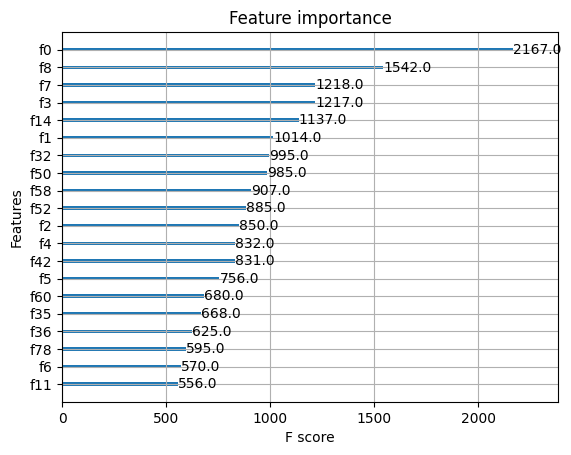

In [ ]:
best_params = {'colsample_bytree': 0.8, 'eta': 0.2, 'lambda': 1.0, 'max_depth': 6, 'subsample': 1.0, 'tree_method': 'hist', 'objective': 'reg:squarederror', 'seed': 42}

final_model = xgb.train(best_params, dtrain, num_boost_round=800)
y_pred_log = final_model.predict(dval)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_val)

rmse = sqrt(mean_squared_error(y_test_original, y_pred))
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")
xgb.plot_importance(final_model, max_num_features=20)  # Plot the top 10 features